In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp meiosis

In [ ]:
from chewc.core import *
import torch

## meiosis
> Simulating Meisois and Recombination for various Crossing actions

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np


ploidy = 2
number_chromosomes = 2
loci_per_chromosome = 5
n_founders = 1
genetic_map = create_random_genetic_map(number_chromosomes,loci_per_chromosome)
crop_genome = Genome(ploidy, number_chromosomes, loci_per_chromosome, genetic_map)
founder_pop = create_random_founder_pop(crop_genome , n_founders)

# Parameters
chromosome_length = 100.0  # Chromosome length (arbitrary units)
num_intervals = 10  # Number of intervals on the chromosome
crossover_rate = 0.1  # Rate of crossover events
interference_strength = 5  # Strength of interference

# Initialize random seed
torch.manual_seed(42)

<torch._C.Generator>

In [ ]:
def gamma_interference_model(length, rate, shape):
    """
    Simulate crossover events using a gamma interference model.
    
    Parameters:
    length (float): Length of the chromosome.
    rate (float): Rate of crossover events.
    shape (float): Shape parameter for the gamma distribution.
    
    Returns:
    torch.Tensor: Positions of crossover events.
    """
    num_crossovers = torch.poisson(torch.tensor([rate * length]))
    intervals = torch.distributions.gamma.Gamma(shape, rate).sample((int(num_crossovers.item()),))
    crossover_positions = torch.cumsum(intervals, dim=0)
    crossover_positions = crossover_positions[crossover_positions < length]
    return crossover_positions




In [ ]:
def simulate_meiosis(num_chromosomes, chromosome_length, crossover_rate, interference_strength):
    """
    Simulate meiosis with crossover events and interference.
    
    Parameters:
    num_chromosomes (int): Number of chromatids.
    chromosome_length (float): Length of the chromosome.
    crossover_rate (float): Rate of crossover events.
    interference_strength (float): Strength of interference.
    
    Returns:
    list of torch.Tensor: List of crossover positions for each chromatid.
    """
    chromatid_crossovers = []
    for _ in range(num_chromosomes):
        crossovers = gamma_interference_model(chromosome_length, crossover_rate, interference_strength)
        chromatid_crossovers.append(crossovers)
    return chromatid_crossovers



Crossover positions: tensor([51.9171])
Chromatid 1 crossover positions: tensor([74.9955, 93.8491])
Chromatid 2 crossover positions: tensor([58.8939])


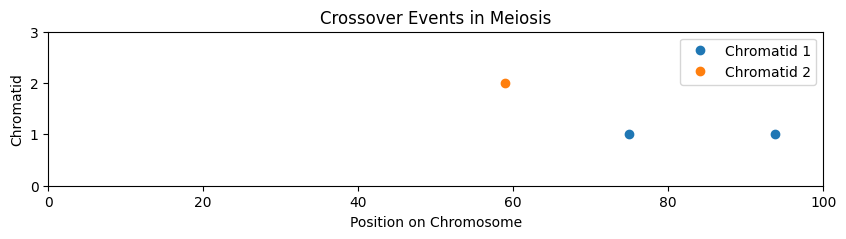

In [ ]:
import matplotlib.pyplot as plt

def plot_crossovers(meiosis_result, chromosome_length):
    plt.figure(figsize=(10, 2))
    for i, crossovers in enumerate(meiosis_result):
        plt.plot(crossovers.numpy(), [i+1] * len(crossovers), 'o', label=f'Chromatid {i+1}')
    plt.xlim(0, chromosome_length)
    plt.ylim(0, number_chromosomes + 1)
    plt.xlabel("Position on Chromosome")
    plt.ylabel("Chromatid")
    plt.title("Crossover Events in Meiosis")
    plt.legend()
    plt.show()
    
    
    
# Example usage
# Example usage
crossovers = gamma_interference_model(chromosome_length, crossover_rate, interference_strength)
print("Crossover positions:", crossovers)
# Example usage
meiosis_result = simulate_meiosis(number_chromosomes, chromosome_length, crossover_rate, interference_strength)
for i, crossovers in enumerate(meiosis_result):
    print(f"Chromatid {i+1} crossover positions:", crossovers)

# Example usage
plot_crossovers(meiosis_result, chromosome_length)

In [ ]:
import torch

def simulate_gametes(crossover_positions, genetic_map, parent_genome):
    """
    Simulate the formation of gametes given crossover positions, genetic map, and parent genomes.

    Parameters:
    crossover_positions (torch.Tensor): Positions of crossover events.
    genetic_map (torch.Tensor): Positions of genetic markers on the chromosomes.
    parent_genome (torch.Tensor): Genomes of the parents.

    Returns:
    torch.Tensor: The resultant gametes.
    """
    num_chromosomes, num_chromatids, num_markers = parent_genome.shape
    resultant_gametes = torch.zeros_like(parent_genome)

    for chrom in range(num_chromosomes):
        for chromatid in range(num_chromatids):
            cross_pos = crossover_positions[chrom]
            markers = genetic_map[chrom]

            # Determine the crossover intervals
            crossover_intervals = torch.bucketize(cross_pos, markers)

            # Alternate the segments between parent chromatids
            source_chromatid = chromatid
            for i in range(num_markers):
                if i > 0 and i in crossover_intervals:
                    source_chromatid = 1 - source_chromatid
                resultant_gametes[chrom, chromatid, i] = parent_genome[chrom, source_chromatid, i]
    
    return resultant_gametes


In [ ]:

# Example usage
genetic_map = torch.tensor([[0.0000, 25.6614, 48.1299, 83.5037, 92.1732],
                            [0.0000,  0.8139,  4.5424, 48.1309, 86.3118]])

parent_genome = torch.tensor([[[0, 1, 0, 1, 0],
                               [0, 1, 0, 0, 1]],

                              [[0, 1, 1, 1, 0],
                               [0, 0, 1, 0, 1]]])

# Example crossover positions
crossover_positions = [torch.tensor([10.0, 50.0]), torch.tensor([5.0, 40.0])]

resultant_gametes = simulate_gametes(crossover_positions, genetic_map, parent_genome)
print("Resultant gametes:", resultant_gametes)


Resultant gametes: tensor([[[0, 1, 0, 1, 0],
         [0, 1, 0, 0, 1]],

        [[0, 1, 1, 0, 1],
         [0, 0, 1, 1, 0]]])


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()